<a href="https://colab.research.google.com/github/swapnafelix/DSND_Term1/blob/master/Casava_leaf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -Uq fastai

     |████████████████████████████████| 194kB 17.1MB/s 
     |████████████████████████████████| 61kB 10.3MB/s 


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"swapnavarier","key":"e1d46f970fe5398bbabb082259e226bf"}'}

In [3]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 9.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=a8d2565a507d5dd953a3e42fda33ed85c9b1a04ac5b4ea7e7ed32291edeedee4
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.76G/5.76G [02:04<00:00, 38.3MB/s]
100% 5.76G/5.76G [02:04<00:00, 49.8MB/s]


In [7]:
!unzip -q cassava-leaf-disease-classification.zip -d dataset

In [8]:
from fastai.vision.all import  *

In [9]:
path = Path('/content/dataset/train_images')
np.random.seed(42)

In [10]:
path.ls()

(#21397) [Path('/content/dataset/train_images/2754438166.jpg'),Path('/content/dataset/train_images/109816879.jpg'),Path('/content/dataset/train_images/3153794511.jpg'),Path('/content/dataset/train_images/263499266.jpg'),Path('/content/dataset/train_images/3439967670.jpg'),Path('/content/dataset/train_images/42609166.jpg'),Path('/content/dataset/train_images/3666805736.jpg'),Path('/content/dataset/train_images/1667727245.jpg'),Path('/content/dataset/train_images/3137997905.jpg'),Path('/content/dataset/train_images/3191863856.jpg')...]

In [11]:
fnames = get_image_files(path)
fnames[0]#print a sample file

Path('/content/dataset/train_images/2754438166.jpg')

In [12]:
train_df = pd.read_csv('/content/dataset/train.csv')
#convert train.csv into a dataframe and print head
train_df.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [13]:
"""
print the shape of the df to see how many rows are there. This should be equal to
the number of records in path. 
"""
train_df.shape

(21397, 2)

In [14]:
def get_x(row): return path/row['image_id']
def get_y(row): return row['label']

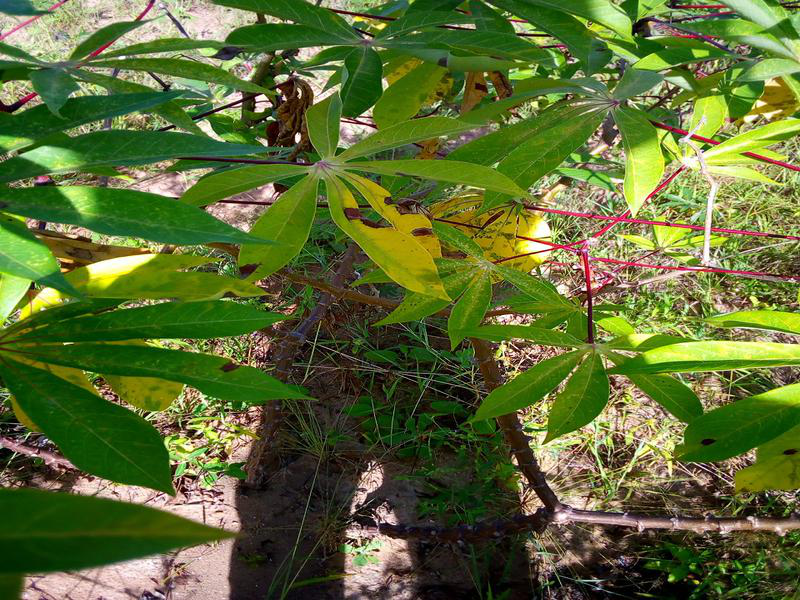

In [15]:
"""
Number of records in the df and the number of items in path file are same. 
"""
#We can print and see any record from the df.
PILImage.create(get_x(train_df.iloc[0]))

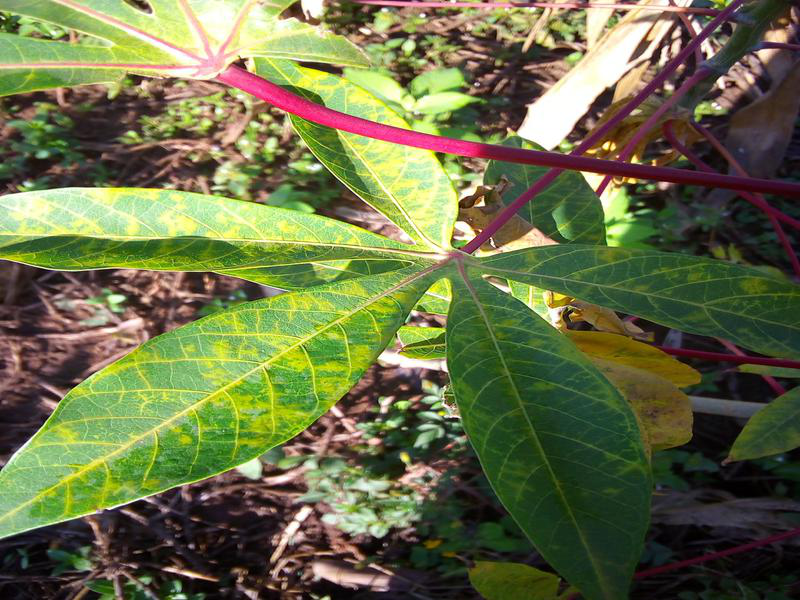

In [16]:
#print one more record
PILImage.create(get_x(train_df.iloc[500]))

In [17]:
train_df['image_id'] = train_df['image_id'].apply(lambda x: f'/content/dataset/train_images/{x}')
train_df.head()

image_id  label
0  /content/dataset/train_images/1000015157.jpg      0
1  /content/dataset/train_images/1000201771.jpg      3
2   /content/dataset/train_images/100042118.jpg      1
3  /content/dataset/train_images/1000723321.jpg      1
4  /content/dataset/train_images/1000812911.jpg      3

In [18]:
label_dict = {0:"Cassava Bacterial Blight (CBB)",
          1:"Cassava Brown Streak Disease (CBSD)",
          2:"Cassava Green Mottle (CGM)",
          3:"Cassava Mosaic Disease (CMD)",
          4:"Healthy"}
train_df['label'].replace(label_dict, inplace=True)
train_df.head()

image_id                                label
0  /content/dataset/train_images/1000015157.jpg       Cassava Bacterial Blight (CBB)
1  /content/dataset/train_images/1000201771.jpg         Cassava Mosaic Disease (CMD)
2   /content/dataset/train_images/100042118.jpg  Cassava Brown Streak Disease (CBSD)
3  /content/dataset/train_images/1000723321.jpg  Cassava Brown Streak Disease (CBSD)
4  /content/dataset/train_images/1000812911.jpg         Cassava Mosaic Disease (CMD)

In [19]:
valid_percent = RandomSplitter(valid_pct=0.2)#training 80% and validation set 20 %

In [20]:
item_tfms = [Resize(448)]#item transforms: each image resize to 448

In [21]:
batch_tfms = [RandomResizedCropGPU(224), *aug_transforms(), Normalize.from_stats(*imagenet_stats)]
#batch transform image by random resize to 224, transofrm and normalize the image.

In [22]:
#In the dataframe a block of image is saved as image: categroy pair.
# image (X value) and category (y- value)
blocks = (ImageBlock, CategoryBlock)

In [23]:
block = DataBlock(blocks=blocks, 
                  get_x = get_x, 
                  get_y = get_y,
                  splitter = valid_percent,
                  item_tfms = item_tfms,
                  batch_tfms = batch_tfms)

In [24]:
#batch size
bs = 64

In [25]:
dls = block.dataloaders(train_df, bs=64)

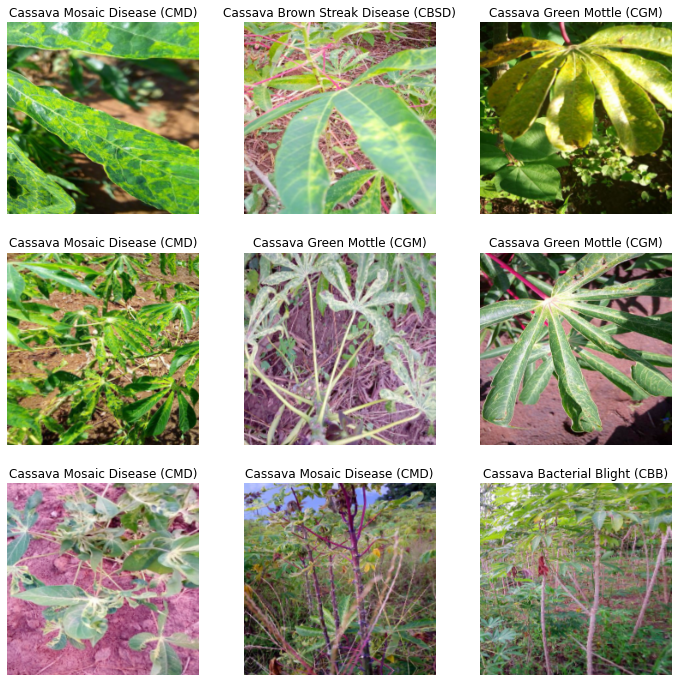

In [26]:
dls.show_batch(figsize=(12, 12))

In [27]:
learn = cnn_learner(dls, resnet34, opt_func= ranger, loss_func= LabelSmoothingCrossEntropy(),
                    metrics = accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [28]:
learn.fit_one_cycle(10)

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

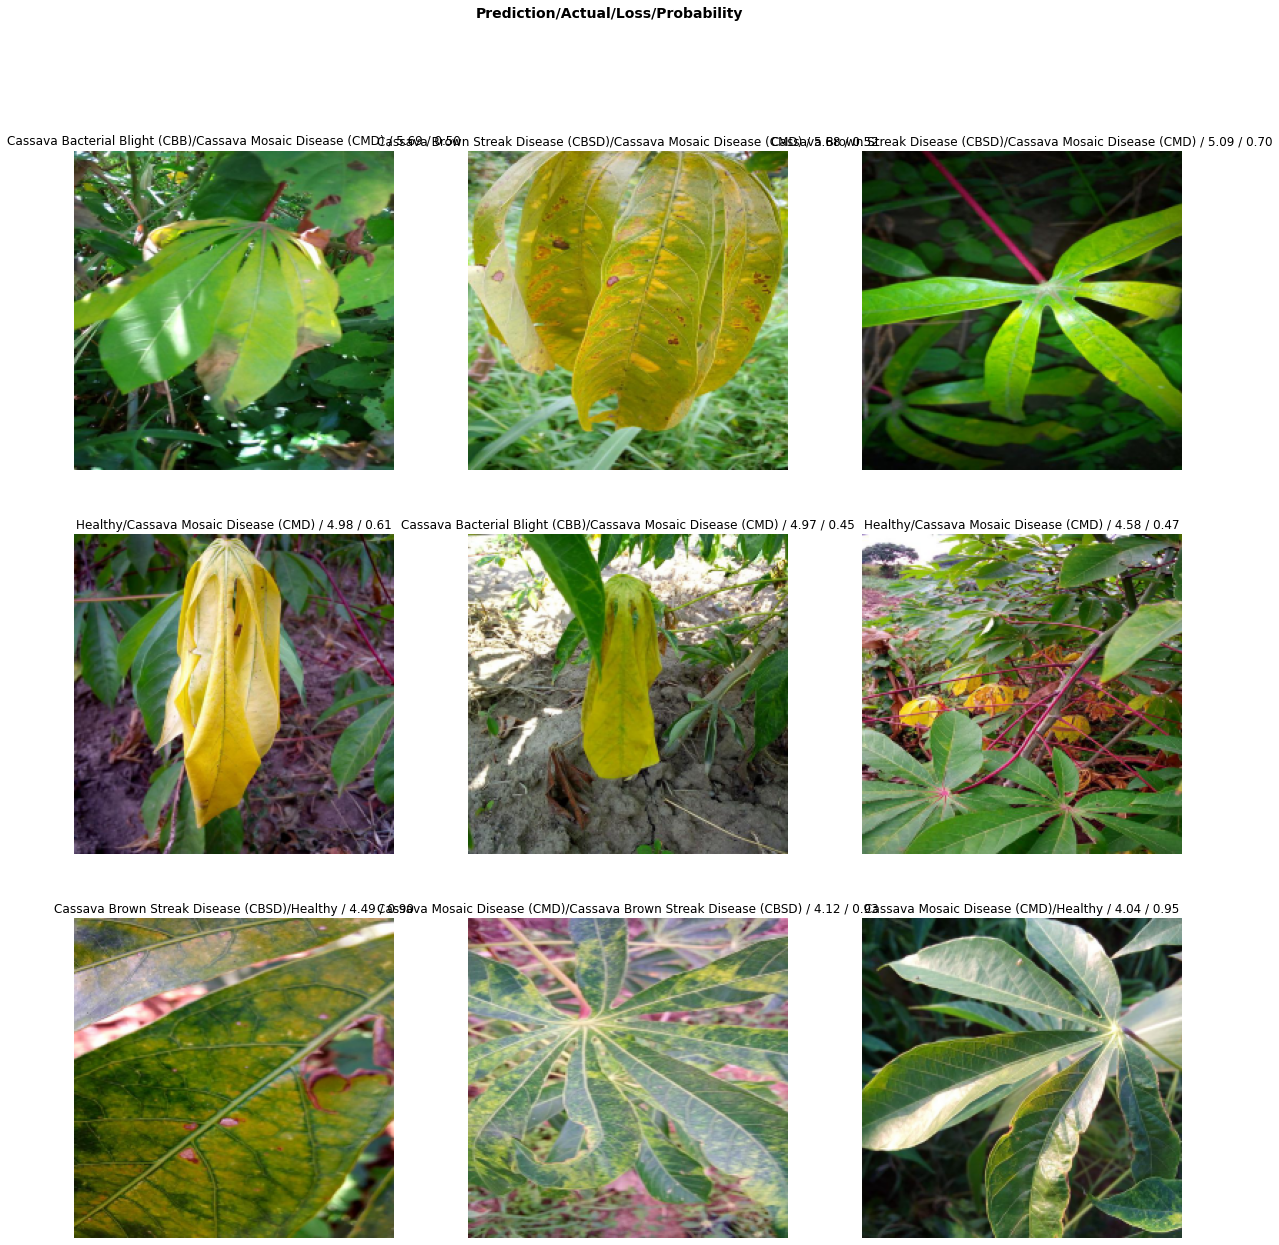

In [33]:
interp.plot_top_losses(9, figsize=(20, 20))

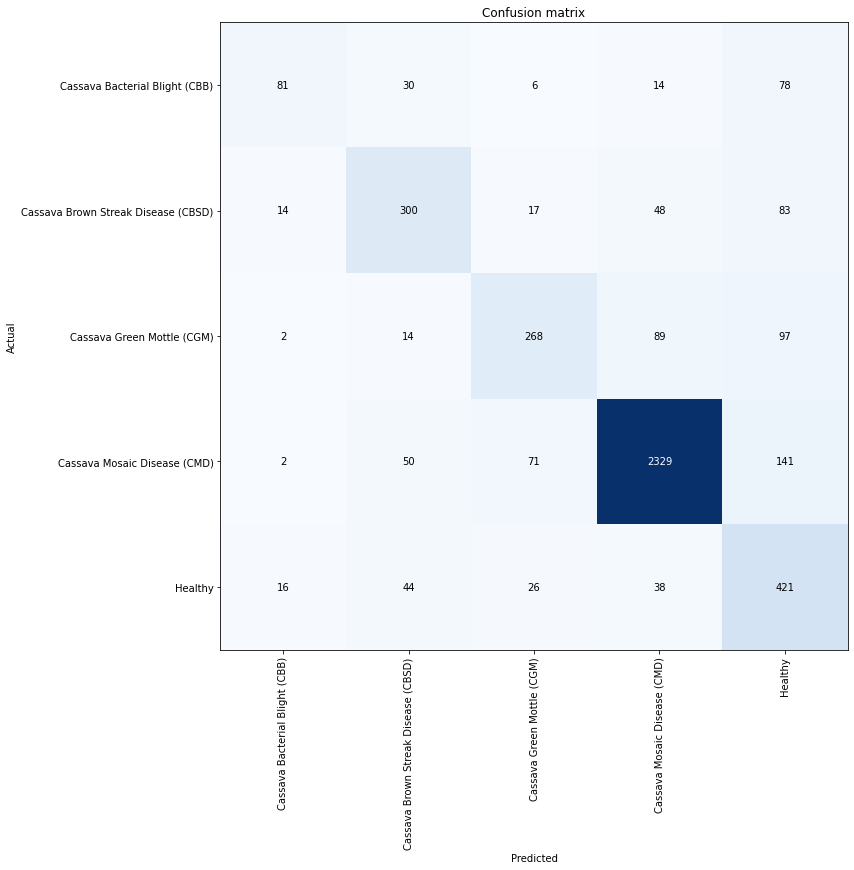

In [34]:
interp.plot_confusion_matrix(figsize = (15, 12))

In [35]:
interp.most_confused(min_val=3)

[('Cassava Mosaic Disease (CMD)', 'Healthy', 141),
 ('Cassava Green Mottle (CGM)', 'Healthy', 97),
 ('Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 89),
 ('Cassava Brown Streak Disease (CBSD)', 'Healthy', 83),
 ('Cassava Bacterial Blight (CBB)', 'Healthy', 78),
 ('Cassava Mosaic Disease (CMD)', 'Cassava Green Mottle (CGM)', 71),
 ('Cassava Mosaic Disease (CMD)', 'Cassava Brown Streak Disease (CBSD)', 50),
 ('Cassava Brown Streak Disease (CBSD)', 'Cassava Mosaic Disease (CMD)', 48),
 ('Healthy', 'Cassava Brown Streak Disease (CBSD)', 44),
 ('Healthy', 'Cassava Mosaic Disease (CMD)', 38),
 ('Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 30),
 ('Healthy', 'Cassava Green Mottle (CGM)', 26),
 ('Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 17),
 ('Healthy', 'Cassava Bacterial Blight (CBB)', 16),
 ('Cassava Bacterial Blight (CBB)', 'Cassava Mosaic Disease (CMD)', 14),
 ('Cassava Brown Streak Disease (CBSD)', 'Cassava Bacterial Bl

In [36]:
learn.unfreeze()

In [37]:
learn.fit_one_cycle(10)

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=7.585775847473997e-07)

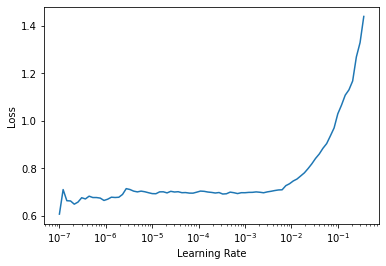

In [38]:
learn.lr_find()

In [39]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-8, 1e-3))

In [40]:
test_path = Path('/content/dataset/test_images')

In [41]:
test_img = get_image_files(test_path)

In [43]:
sample_df = pd.read_csv('/content/dataset/sample_submission.csv')
sample_df.head()

image_id  label
0  2216849948.jpg      4

In [45]:
sample_copy = sample_df.copy()
sample_copy['image_id'] = sample_copy['image_id'].apply(lambda x: f'/content/dataset/test_images/{x}')

In [46]:
test_dls = learn.dls.test_dl(sample_copy)

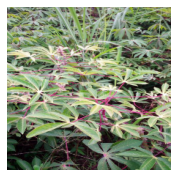

In [48]:
test_dls.show_batch()

In [49]:
preds, _ = learn.get_preds(dl=test_dls)

In [50]:
preds.shape

torch.Size([1, 5])

In [51]:
sample_df['label'] = preds.argmax(dim=-1).numpy()

In [52]:
sample_df.head()

image_id  label
0  2216849948.jpg      4

In [59]:
learn.predict('/content/dataset/Casava_test_sample/CGM.jpeg')

('Cassava Green Mottle (CGM)',
 tensor(2),
 tensor([0.0508, 0.0459, 0.7527, 0.0741, 0.0766]))

In [57]:
learn.predict('/content/dataset/Casava_test_sample/CBSD_1.jpg')

('Cassava Green Mottle (CGM)',
 tensor(2),
 tensor([0.0464, 0.0905, 0.5344, 0.2132, 0.1154]))

In [58]:
learn.predict('/content/dataset/Casava_test_sample/CBSD_2.jpeg')

('Cassava Brown Streak Disease (CBSD)',
 tensor(1),
 tensor([0.0184, 0.9163, 0.0238, 0.0266, 0.0149]))

In [60]:
learn.predict('/content/dataset/Casava_test_sample/cassava-bacterial-blight-manioc-1.jpg')

('Cassava Brown Streak Disease (CBSD)',
 tensor(1),
 tensor([0.1072, 0.7182, 0.0484, 0.0522, 0.0739]))

In [61]:
learn.predict('/content/dataset/Casava_test_sample/cgmv.jpg')

('Cassava Mosaic Disease (CMD)',
 tensor(3),
 tensor([0.0221, 0.0106, 0.1856, 0.7143, 0.0675]))